# Abstract

Se calcularon espectrogramas STFT (ventana de 25 ms, 50 % de solapamiento, n_fft=1024) y se convirtieron a escala logarítmica (dB). De forma alternativa, se obtuvo un espectrograma Mel (40 bandas) en dB con los mismos parámetros temporales. A partir del log-Mel se extrajeron 13 MFCC; para visualización y modelado se aplicó normalización cepstral por coeficiente (CMVN) y se excluyó C0 (energía), dada su dominancia y baja utilidad discriminativa.

In [7]:
import os, math, json
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

# === Ruta del audio ===
audio_path = r"c:\Users\leona\Documents\Thesis_Project_UACH\Temp\Dataset\BeesAnna\sound_files\2022-06-08--14-52-28_1__segment3.wav"

# === Parámetros explícitos: 25 ms de ventana, 50% de solape ===
sr = 22050
win_length = int(round(0.025 * sr))          # ~551 muestras
hop_length = int(round(0.5 * win_length))    # ~276 muestras
# n_fft >= win_length y idealmente potencia de 2
n_fft = 1
while n_fft < win_length:
    n_fft <<= 1                               # -> 1024

n_mels = 40
n_mfcc = 13

# === Cargar audio ===
y, sr = librosa.load(audio_path, sr=sr)

base_name = os.path.splitext(os.path.basename(audio_path))[0]
print({
    "sr": sr,
    "win_length": win_length,
    "hop_length": hop_length,
    "n_fft": n_fft,
    "n_mels": n_mels,
    "n_mfcc": n_mfcc,
})


{'sr': 22050, 'win_length': 551, 'hop_length': 276, 'n_fft': 1024, 'n_mels': 40, 'n_mfcc': 13}


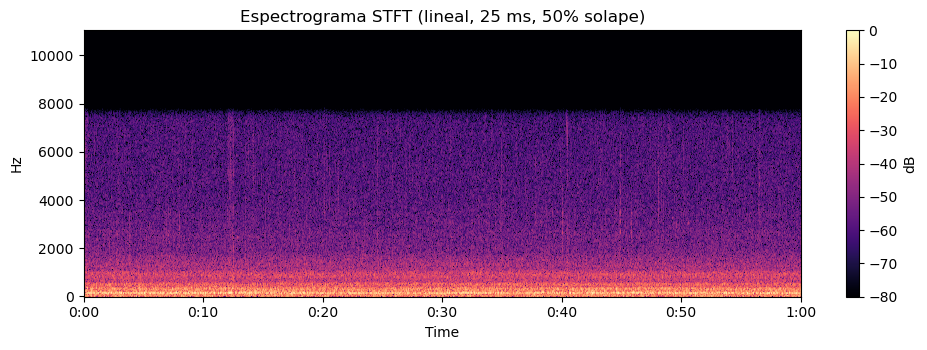

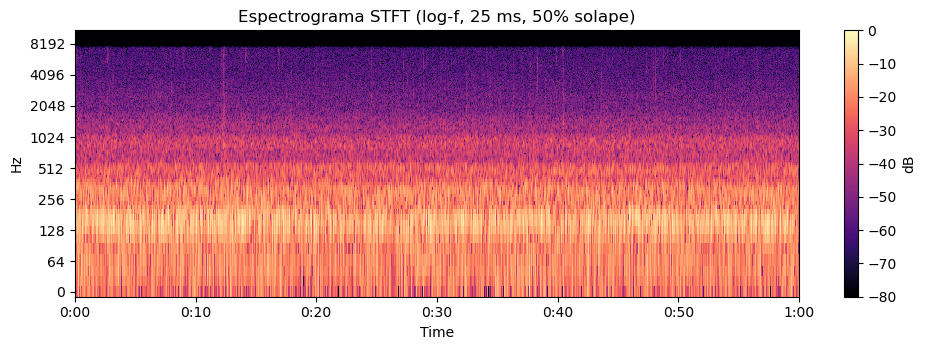

In [8]:
# === STFT y potencia en dB ===
stft = librosa.stft(
    y, n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    window="hann", center=True
)
power = np.abs(stft) ** 2
power_db = librosa.power_to_db(power, ref=np.max)

# --- Espectrograma lineal ---
plt.figure(figsize=(10, 3.6))
librosa.display.specshow(
    power_db, x_axis="time", y_axis="linear",
    sr=sr, hop_length=hop_length, cmap="magma"
)
plt.colorbar(label="dB")
plt.title("Espectrograma STFT (lineal, 25 ms, 50% solape)")
plt.tight_layout()
plt.savefig(f"{base_name}_stft_linear.png", dpi=300)
plt.show()

# --- Espectrograma con eje de frecuencias logarítmico (útil para visualización) ---
plt.figure(figsize=(10, 3.6))
librosa.display.specshow(
    power_db, x_axis="time", y_axis="log",
    sr=sr, hop_length=hop_length, cmap="magma"
)
plt.colorbar(label="dB")
plt.title("Espectrograma STFT (log-f, 25 ms, 50% solape)")
plt.tight_layout()
plt.savefig(f"{base_name}_stft_log.png", dpi=300)
plt.show()

# --- Guardado de arrays ---
np.save(f"{base_name}_stft_power_db.npy", power_db)   # [freq_bins x frames]


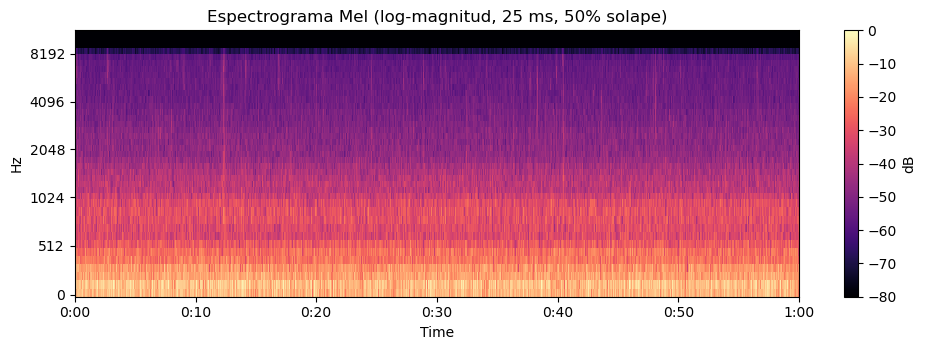

In [9]:
# === Espectrograma Mel y dB ===
S = librosa.feature.melspectrogram(
    y=y, sr=sr, n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    n_mels=n_mels, power=2.0, fmin=20, fmax=sr/2
)
S_db = librosa.power_to_db(S, ref=np.max)  # [n_mels x frames]

plt.figure(figsize=(10, 3.6))
librosa.display.specshow(
    S_db, x_axis="time", y_axis="mel",
    sr=sr, hop_length=hop_length, fmin=20, fmax=sr/2, cmap="magma"
)
plt.colorbar(label="dB")
plt.title("Espectrograma Mel (log-magnitud, 25 ms, 50% solape)")
plt.tight_layout()
plt.savefig(f"{base_name}_mel_db.png", dpi=300)
plt.show()

np.save(f"{base_name}_mel_db.npy", S_db)   # [n_mels x frames]


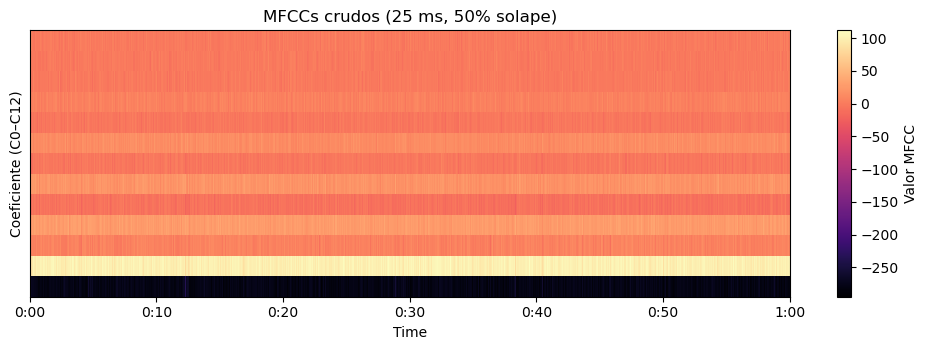

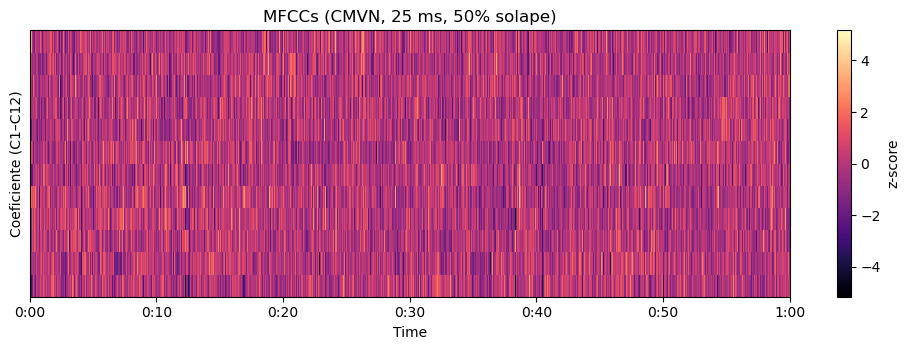

Shapes -> S_db: (40, 4794) mfcc_raw: (13, 4794) mfcc_cmvn: (12, 4794)


In [10]:
# === MFCCs desde log-Mel (coherente con el front-end) ===
mfcc_raw = librosa.feature.mfcc(S=S_db, n_mfcc=n_mfcc)  # [13 x frames], incluye C0

# === Normalización cepstral (CMVN) y exclusión de C0 (recomendado para figura/análisis) ===
mfcc = mfcc_raw[1:, :]                                  # C1..C12
mu = mfcc.mean(axis=1, keepdims=True)
sd = mfcc.std(axis=1, keepdims=True) + 1e-8
mfcc_cmvn = (mfcc - mu) / sd                            # [12 x frames]

# --- Figura: MFCCs crudos ---
plt.figure(figsize=(10, 3.6))
librosa.display.specshow(
    mfcc_raw, x_axis="time", sr=sr, hop_length=hop_length, cmap="magma"
)
plt.colorbar(label="Valor MFCC")
plt.ylabel("Coeficiente (C0–C12)")
plt.title("MFCCs crudos (25 ms, 50% solape)")
plt.tight_layout()
plt.savefig(f"{base_name}_mfcc_raw.png", dpi=300)
plt.show()

# --- Figura: MFCCs normalizados (CMVN, sin C0) ---
plt.figure(figsize=(10, 3.6))
librosa.display.specshow(
    mfcc_cmvn, x_axis="time", sr=sr, hop_length=hop_length, cmap="magma"
)
plt.colorbar(label="z-score")
plt.ylabel("Coeficiente (C1–C12)")
plt.title("MFCCs (CMVN, 25 ms, 50% solape)")
plt.tight_layout()
plt.savefig(f"{base_name}_mfcc_cmvn.png", dpi=300)
plt.show()

print("Shapes ->",
      "S_db:", S_db.shape,
      "mfcc_raw:", mfcc_raw.shape,
      "mfcc_cmvn:", mfcc_cmvn.shape)


In [11]:
# === Guardado consistente ===
# Arrays estándar (orientación [n_features x frames]):
np.save(f"{base_name}_mfcc_raw.npy", mfcc_raw)     # [13 x frames]
np.save(f"{base_name}_mfcc_cmvn.npy", mfcc_cmvn)   # [12 x frames]

# CSV en [frames x n_features] para compatibilidad con tu flujo anterior:
import pandas as pd
pd.DataFrame(mfcc_raw.T).to_csv(f"{base_name}_mfcc_raw.csv", index=False)
pd.DataFrame(mfcc_cmvn.T).to_csv(f"{base_name}_mfcc_cmvn.csv", index=False)

# === Metadatos para reproducibilidad ===
params = dict(
    sr=sr,
    win_length=win_length,
    hop_length=hop_length,
    n_fft=n_fft,
    n_mels=n_mels,
    n_mfcc=n_mfcc,
    fmin=20,
    fmax=float(sr/2),
    window="hann",
    center=True
)
with open(f"{base_name}_params.json", "w") as f:
    json.dump(params, f, indent=2)

print("Guardado OK:")
print(f"- {base_name}_stft_power_db.npy")
print(f"- {base_name}_mel_db.npy")
print(f"- {base_name}_mfcc_raw.npy / .csv")
print(f"- {base_name}_mfcc_cmvn.npy / .csv")
print(f"- {base_name}_params.json")


Guardado OK:
- 2022-06-08--14-52-28_1__segment3_stft_power_db.npy
- 2022-06-08--14-52-28_1__segment3_mel_db.npy
- 2022-06-08--14-52-28_1__segment3_mfcc_raw.npy / .csv
- 2022-06-08--14-52-28_1__segment3_mfcc_cmvn.npy / .csv
- 2022-06-08--14-52-28_1__segment3_params.json


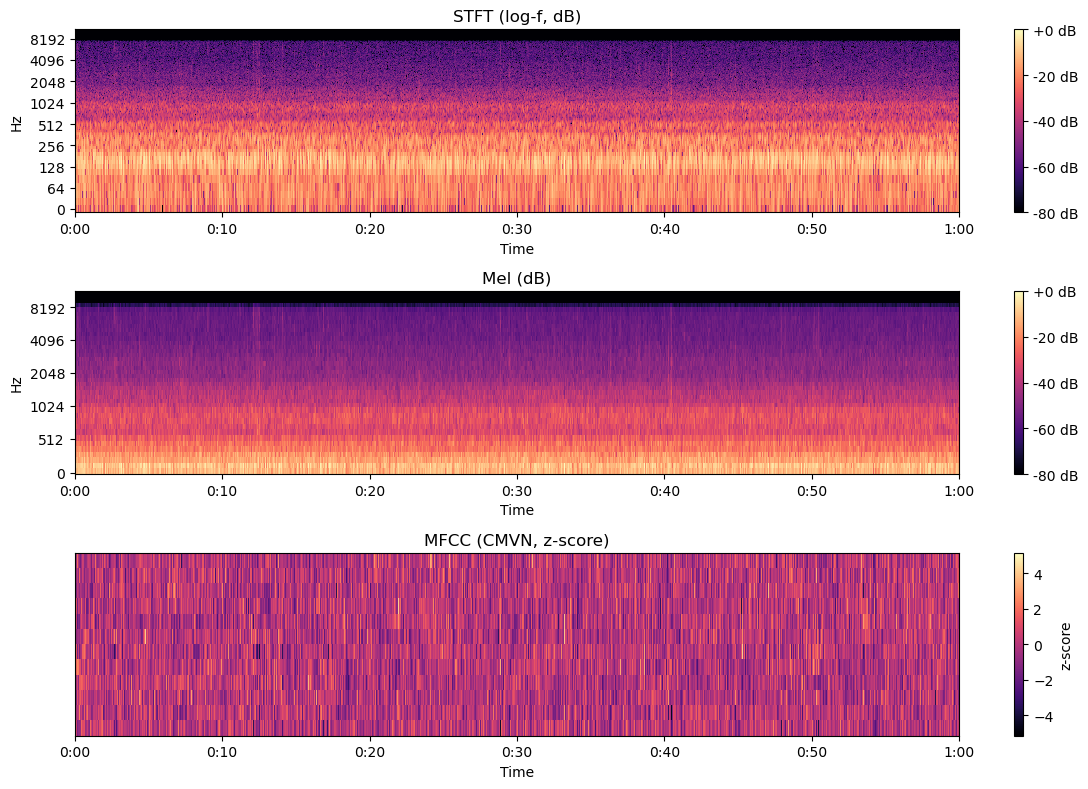

In [12]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[1,1,1], figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
img1 = librosa.display.specshow(
    power_db, x_axis="time", y_axis="log", sr=sr, hop_length=hop_length,
    cmap="magma", ax=ax1
)
ax1.set_title("STFT (log-f, dB)")
fig.colorbar(img1, ax=ax1, format="%+2.0f dB")

ax2 = fig.add_subplot(gs[1, 0])
img2 = librosa.display.specshow(
    S_db, x_axis="time", y_axis="mel", sr=sr, hop_length=hop_length,
    cmap="magma", fmin=20, fmax=sr/2, ax=ax2
)
ax2.set_title("Mel (dB)")
fig.colorbar(img2, ax=ax2, format="%+2.0f dB")

ax3 = fig.add_subplot(gs[2, 0])
img3 = librosa.display.specshow(
    mfcc_cmvn, x_axis="time", sr=sr, hop_length=hop_length,
    cmap="magma", ax=ax3
)
ax3.set_title("MFCC (CMVN, z-score)")
fig.colorbar(img3, ax=ax3, label="z-score")

plt.tight_layout()
#plt.savefig(f"{base_name}_stft_mel_mfcc_panel.png", dpi=300)
plt.show()
